Задача: Смоделировать исследование проведенного AB-теста. Предложить гипотезу, метрики и проанализировать эксперимент.

## 1. Знакомство с данными

### Описание данных

Таблица `wid_ab_test_dataset` содержит информацию о пользователях, которые участвовали в a-b тестировании по расширению функционал приложения WID.\
Поля таблицы:

- `user_id` — идентификатор пользователя;

- `group` — группа эксперимента;

- `visited` — количество визитов;

- `signed_up` — количество регистраций;

- `subscribed` — количество подписок;

- `revenue` — выручка с подписки;

In [1]:
# Грузим библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from matplotlib.colors import (
    LinearSegmentedColormap,
)  # поможет расскарсить датафрейм см. ниже :)

warnings.filterwarnings("ignore")  # бережем глаза от ненужных предупреждений

In [2]:
# Грузим датасет
df = pd.read_csv("wid_ab_test_dataset - ab_test.csv")

In [3]:
# Выводим оснвную информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     800 non-null    int64 
 1   group       800 non-null    object
 2   visited     800 non-null    int64 
 3   signed_up   800 non-null    int64 
 4   subscribed  800 non-null    int64 
 5   revenue     800 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 37.6+ KB


Всего в датафрейме 800 строк и 6 столбцов. Пустых полей не обнаружено. Типы данных в событиях можно оптимизировать

In [4]:
# Приведем значения в столбцах 'visited','signed_up', 'subscribed' к булевому типу данных
df[["visited", "signed_up", "subscribed"]] = df[
    ["visited", "signed_up", "subscribed"]
].astype("bool")

In [5]:
#Познакомимся с данными
df.head(10)

,user_id,group,visited,signed_up,subscribed,revenue
0,1,A,True,True,False,0
1,2,A,True,True,True,438
2,3,A,True,False,False,0
3,4,A,True,True,False,0
4,5,A,True,False,False,0
5,6,B,True,True,False,0
6,7,A,True,False,False,0
7,8,A,True,False,False,0
8,9,B,True,True,False,0
9,10,B,True,True,False,0


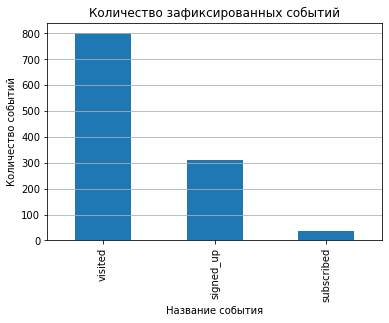

In [6]:
#Визуализируем количесто событий
total_events = df[['visited', 'signed_up', 'subscribed']].sum()

total_events.plot(kind='bar')
plt.title('Количество зафиксированных событий')
plt.xlabel('Название события')
plt.ylabel('Количество событий')
plt.grid(True, axis='y')
plt.show()

Учитывая размер выборки (800 строк), можем предположит, что событий 'suscribed' может быть недостаточно для получения значимых изменений. Поэтому построим гипотезу на базе количества регистраций.

## 2. Дизайн a-b теста

Перед тем как проводить А/B-тест, смоделируем ситуацию/
1. Определим гипотезу, 
2. Выберим ключевую метрику на основе объема данных
3. Сформируем нулевую и альтернативную гипотезы.

**Гипотеза**: Если мы добавим регистрацию по Яндекс.ID, то сможем увеличить конверсию в регистрацию на 11 п.п от среднего значения в 30%

**Ключевая метрика**. Конверсия из визита в регистрацию. Учитывая, что метрика долевая будем использовать z-тест пропорций

**Формируем нулевую и альтернативную гипотезы**\
Н0: Доля зарегистрированных пользователей не различаются при добавление регистрации по Яндекс.ID\
H1: Доля зарегистрированных пользователей выше при наличии регистрации по Яндекс.ID

## 3. Проверка данных и мониторинг AB-теста

##### 3.1 Проверим дубли и пересечения

In [7]:
# Проверим наличие полных дубликатов
df.duplicated().sum()

0

Полных дубликатов нет

In [8]:
# Проверим дубликаты по столбцу user_id
df["user_id"].duplicated().sum()

0

Дубликатов по полю user_id также не найдено

In [9]:
# Проверим пересечение пользователей между двумя группами
a = df[df["group"] == "A"]["user_id"]
b = df[df["group"] == "B"]["user_id"]

intersection = list(set(a) & set(b))
print(intersection)

[]


Пользователи в группах уникальны

##### 3.2 Проверим размеры групп

In [10]:
# Посчитаем количество пользователей в первой и второй группах
a_group = df[df["group"] == "A"]["user_id"].nunique()
b_group = df[df["group"] == "B"]["user_id"].nunique()
diff = b_group - a_group

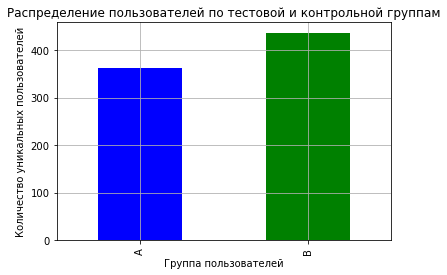

Количество участников в группах a и b: 363, 437
Разница в количестве пользователей: 74 пользователя в пользу тестовой группы
Доля пользователей в группе A - 45.375%, Доля пользователей в группе B - 54.625%. Разница между группами 9.25 п.п


In [11]:
# Визуализируем количество пользователей по группам
colors = ["blue", "green"]
df.groupby("group")["user_id"].nunique().plot(kind="bar", color=colors)
plt.title("Распределение пользователей по тестовой и контрольной группам")
plt.xlabel("Группа пользователей")
plt.ylabel("Количество уникальных пользователей")
plt.grid(True)
plt.show()
print(f"Количество участников в группах a и b: {a_group}, {b_group}")
print(
    f"Разница в количестве пользователей: {diff} пользователя в пользу тестовой группы"
)
# Посмотрим доли пользователей тестовой и контрольный групп от всех пользователей
share_a = 100.0 * a_group / df["user_id"].nunique()
share_b = 100.0 * b_group / df["user_id"].nunique()
share_diff = share_b - share_a
print(
    f"Доля пользователей в группе A - {share_a}%, Доля пользователей в группе B - {share_b}%. Разница между группами {share_diff} п.п"
)

##### 3.3 Расчитаем минимальный объем наблюдений

По калькулятору Эвана Миллера для долевых метрик при значимости теста 0.05, мощности 80%, базовому значению 30% и абсолютном MDE 11% необходимо минимум 279 пользователей на группу. Минимальный размер пользователей достигнут

#### Выводы
Количество уникальных пользователей в группе A = 363, в группе B = 437\
Расхождение между группами составило 9.25 п.п. В идеале, нужно перезапустить тест, т.к различия могут влиять на результаты, но упустим этот момент в данном кейсе, чтобы продолжить исследование\
Пересечений между группа не обнаружено.\
Требования к минимальному объему наблюдений для ожидаемого эффекта выполняются\

## 4. Проверка результатов A/B-теста

##### 4.1 Посчитаем коэффициент конверсии и сравним насколько различаются значения в тестовой и контрольной групп

In [12]:
# Сравним конверсию в регистрацию по группам
df_users_signed_up = df.groupby(["user_id", "group"])["signed_up"].sum().reset_index()
df_users_visit = df.groupby(["user_id", "group"])["visited"].sum().reset_index()
visited = df_users_visit.groupby("group")["visited"].sum()
signed = df_users_signed_up.groupby("group")["signed_up"].sum()
display(100.0 * signed / visited)
cr_test = 100.0 * signed["B"] / visited["B"]
cr_control = 100.0 * signed["A"] / visited["A"]


print(
    f"Относительное изменение конверсии составило +{round((cr_test - cr_control) / cr_control * 100.0,2)}% "
)
print(
    f"Абсолютное изменение конверсии составило +{round(cr_test - cr_control,2)} п.п. "
)
print(
    f"Конверсия в регистрацию у контрольной группы составила {round(cr_control,2)}%. Конверсия регистрацию в тестовой группе составила {round(cr_test,2)}%"
)

group
A    34.710744
B    41.876430
dtype: float64

Относительное изменение конверсии составило +20.64% 
Абсолютное изменение конверсии составило +7.17 п.п. 
Конверсия в регистрацию у контрольной группы составила 34.71%. Конверсия регистрацию в тестовой группе составила 41.88%


In [13]:
#проверим, выполняется ли предпосылка Z-теста пропорций о достаточном размере выборок
n_a, n_b = a_group, b_group ## размеры выборок A и B
m_a = signed["A"] # количество успехов (регистраций) в группе A
m_b = signed["B"] # количество успехов (регистраций) в группе B

p_a, p_b = m_a/n_a, m_b/n_b

print(f'n_a={n_a}, n_b={n_b}')

print(f'm_a={m_a}, m_b={m_b}')

print(f'p_a={p_a}, p_b={p_b}')

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

n_a=363, n_b=437
m_a=126, m_b=183
p_a=0.34710743801652894, p_b=0.41876430205949655
Предпосылка о достаточном количестве данных выполняется!


In [15]:
from statsmodels.stats.proportion import proportions_ztest
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative = 'smaller'
)

p_value_ztest

if p_value_ztest < alpha:
    print(f'p_value {p_value_ztest} < alpha {alpha}')
    print('Нулевая гипотеза не находит подтверждения')
else:
    print(f' p_value {p_value_ztest} > alpha {alpha}')
    print('Нулевая гипотеза находит подтверждения')

p_value 0.01911335345363429 < alpha 0.05
Нулевая гипотеза не находит подтверждения


#### Выводы по результатам эксперимента 
Аудитория была разделена на две группы. В контрольной группе A 363 пользователя, в тестовой - 437 пользователей. В качестве ключевой метрики была выбрана доля регистраций

Выборки независимы, но различны по размеру. Предпосылка о достаточном размере выборок выполняется.

По результатам проведенного эксперимента выяснили, что доля успешных сессий в группе A = **34.71%**, а в группе B = **41.87%**. Lift конверсии в регистрацию в тестовой группе составили **+20.64%**. 
Прирост конверсии в тестовой группе составило **+7.17 п.п**. На основе проведенного Z-тест пропорций, pvalue составил **0.0191** и меньше уровня значимости, из чего следует вывод, что **изменения статистически значимы**.

**Гипотеза о том, что регистрация по Яндекс ID положительно влияет на долю регистраций в рамках выборки нашла свое подтверждение**